In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
src_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/results/full'

In [3]:
file_names = os.listdir(src_dir_path)
file_names.sort()

k_ex = ['999', '998', '997', 'encoding', 'rep-', 'snntorch', 'wandb']
#k_ex = [id+'_' for id in k_ex]

mod_file_names = []
for file_name in file_names:
    # if there exists any id in k_ex, remove from file_names
    if any(id_ in file_name for id_ in k_ex):
        continue
    mod_file_names.append(file_name)
file_names = mod_file_names

In [4]:
# group_key를 키로, 해당 group_key에 대한 모델별 성능을 담는 DataFrame을 값으로 하는 딕셔너리
# 예: {'SMD': DataFrame, 'MSL': DataFrame, ...}
# 각 DataFrame은 'Model'을 인덱스로 갖고 'Mean VUS-PR', 'Total Time' 컬럼을 가짐
grouped_performance_dfs = {}

for idx, result_file_name in enumerate(file_names): # 각 파일은 특정 모델(또는 설정)의 결과로 간주
    #if idx > 10: # 테스트를 위해 처음 3개 파일만 처리
    #    break
    
    file_path = os.path.join(src_dir_path, result_file_name)
    df = pd.read_csv(file_path)
    
    # 모델 식별자 (예: '001_ARIMA_hyperopt_full_209')
    model_identifier = result_file_name.split('.csv')[0] 
    
    # 'file' 컬럼(개별 시계열 파일명)을 '_'로 스플릿하여 두 번째 값을 기준으로 그룹화
    # 예: '001_SMD_datafile.csv' -> 'SMD'
    df['group_key'] = df['file'].apply(lambda x: x.split('_')[1])
    grouped_by_dataset_type = df.groupby('group_key')

    for group_name, group_data in grouped_by_dataset_type:
        group_mean_vus_pr = group_data['VUS-PR'].mean()
        group_total_time = group_data['Time'].sum()
        
        # 해당 group_name의 DataFrame이 아직 없으면 새로 생성
        if group_name not in grouped_performance_dfs:
            grouped_performance_dfs[group_name] = pd.DataFrame(columns=['Mean VUS-PR', 'Total Time'])
            grouped_performance_dfs[group_name].index.name = 'Model'
            
        # 현재 모델의 성능을 해당 group_name DataFrame에 레코드로 추가
        grouped_performance_dfs[group_name].loc[model_identifier] = [group_mean_vus_pr, group_total_time]

# 결과 확인 (예시: 각 그룹별 DataFrame의 첫 5줄 출력)
for group_name, performance_df in grouped_performance_dfs.items():
    pass
    #print(f"\n--- Performance for Dataset Group: {group_name} ---")
    #print(performance_df.head())

In [5]:
# 1. 모든 그룹에서 나타나는 전체 모델 목록을 가져오고 색상 매핑을 생성합니다.
all_models_set = set()
if grouped_performance_dfs:
    for df_ in grouped_performance_dfs.values():
        all_models_set.update(df_.index.tolist())
all_models_list = sorted(list(all_models_set))

In [6]:
# 모든 모델-그룹 조합에 대한 Mean VUS-PR을 담을 데이터프레임 생성
group_names = list(grouped_performance_dfs.keys())
heatmap_df_vus_pr = pd.DataFrame(index=all_models_list, columns=group_names)
heatmap_df_time = pd.DataFrame(index=all_models_list, columns=group_names)

# 값 채우기
for group_name, df in grouped_performance_dfs.items():
    for model in df.index:
        if model in heatmap_df_vus_pr.index:
            heatmap_df_vus_pr.loc[model, group_name] = df.loc[model, 'Mean VUS-PR']
        if model in heatmap_df_time.index:
            heatmap_df_time.loc[model, group_name] = df.loc[model, 'Total Time']

# 결측값은 0 또는 np.nan으로 채우기 (선택)
heatmap_df_vus_pr = heatmap_df_vus_pr.astype(float).fillna(0)
heatmap_df_time = heatmap_df_time.astype(float).fillna(0)

In [7]:
# filter value is less than 0.1
heatmap_df_vus_pr = heatmap_df_vus_pr[heatmap_df_vus_pr >= 0.1]

# get max value on each column
max_vus_pr = heatmap_df_vus_pr.max()
mean_vus_pr = heatmap_df_vus_pr.mean()
error_vus_pr = max_vus_pr - mean_vus_pr

print("Error VUS-PR:")
# print with percentage and model name
for model, error in error_vus_pr.items():
    print(f"{model}: {error:.2%}")

Error VUS-PR:
CATSv2: 5.35%
CreditCard: 0.13%
Daphnet: 12.41%
Exathlon: 4.04%
GECCO: 8.23%
GHL: 14.52%
Genesis: 0.39%
LTDB: 18.98%
MITDB: 7.98%
MSL: 23.30%
OPPORTUNITY: 14.96%
PSM: 7.06%
SMAP: 14.67%
SMD: 9.05%
SVDB: 28.15%
SWaT: 5.60%
TAO: 0.42%


In [8]:
def viz_heatmap(heatmap_df):
    # ➊ 열마다 최대값 위치 파악
    max_pos_mask = heatmap_df.eq(heatmap_df.max(axis=0))

    fig, ax = plt.subplots(figsize=(1.2 * heatmap_df.shape[1], 0.4 * heatmap_df.shape[0]))

    # ➋ 기본 heatmap (annot 없이)
    sns.heatmap(
        heatmap_df,
        cmap='viridis',
        annot=False,
        fmt=".3f",
        linewidths=0.5,
        linecolor='lightgray',
        cbar_kws={'label': 'Mean VUS-PR'},
        ax=ax
    )

    # ➌ 각 셀에 수치 표시 + 최대값이면 빨간색
    for i in range(heatmap_df.shape[0]):  # row
        for j in range(heatmap_df.shape[1]):  # column
            value = heatmap_df.iloc[i, j]
            is_max = max_pos_mask.iloc[i, j]
            if value <= 0.1:
                color = 'yellow'
                fontweight = 'bold'
            elif value >= 0.8:
                color = 'black'
                fontweight = 'normal'
            else:
                color = 'white'
                fontweight = 'normal'
            if is_max:
                color = 'red'
                fontweight = 'bold'
            ax.text(j + 0.5, i + 0.5, f"{value:.3f}", 
                    ha='center', va='center', color=color, 
                    fontsize=10, fontweight=fontweight)

    # ⬆️ X축 눈금을 위로
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    ax.set_ylabel("Model")
    ax.set_title("Model Performance (Mean VUS-PR) Heatmap", pad=20)

    if heatmap_df.shape[1] > 10:
        plt.tight_layout()
    plt.show()

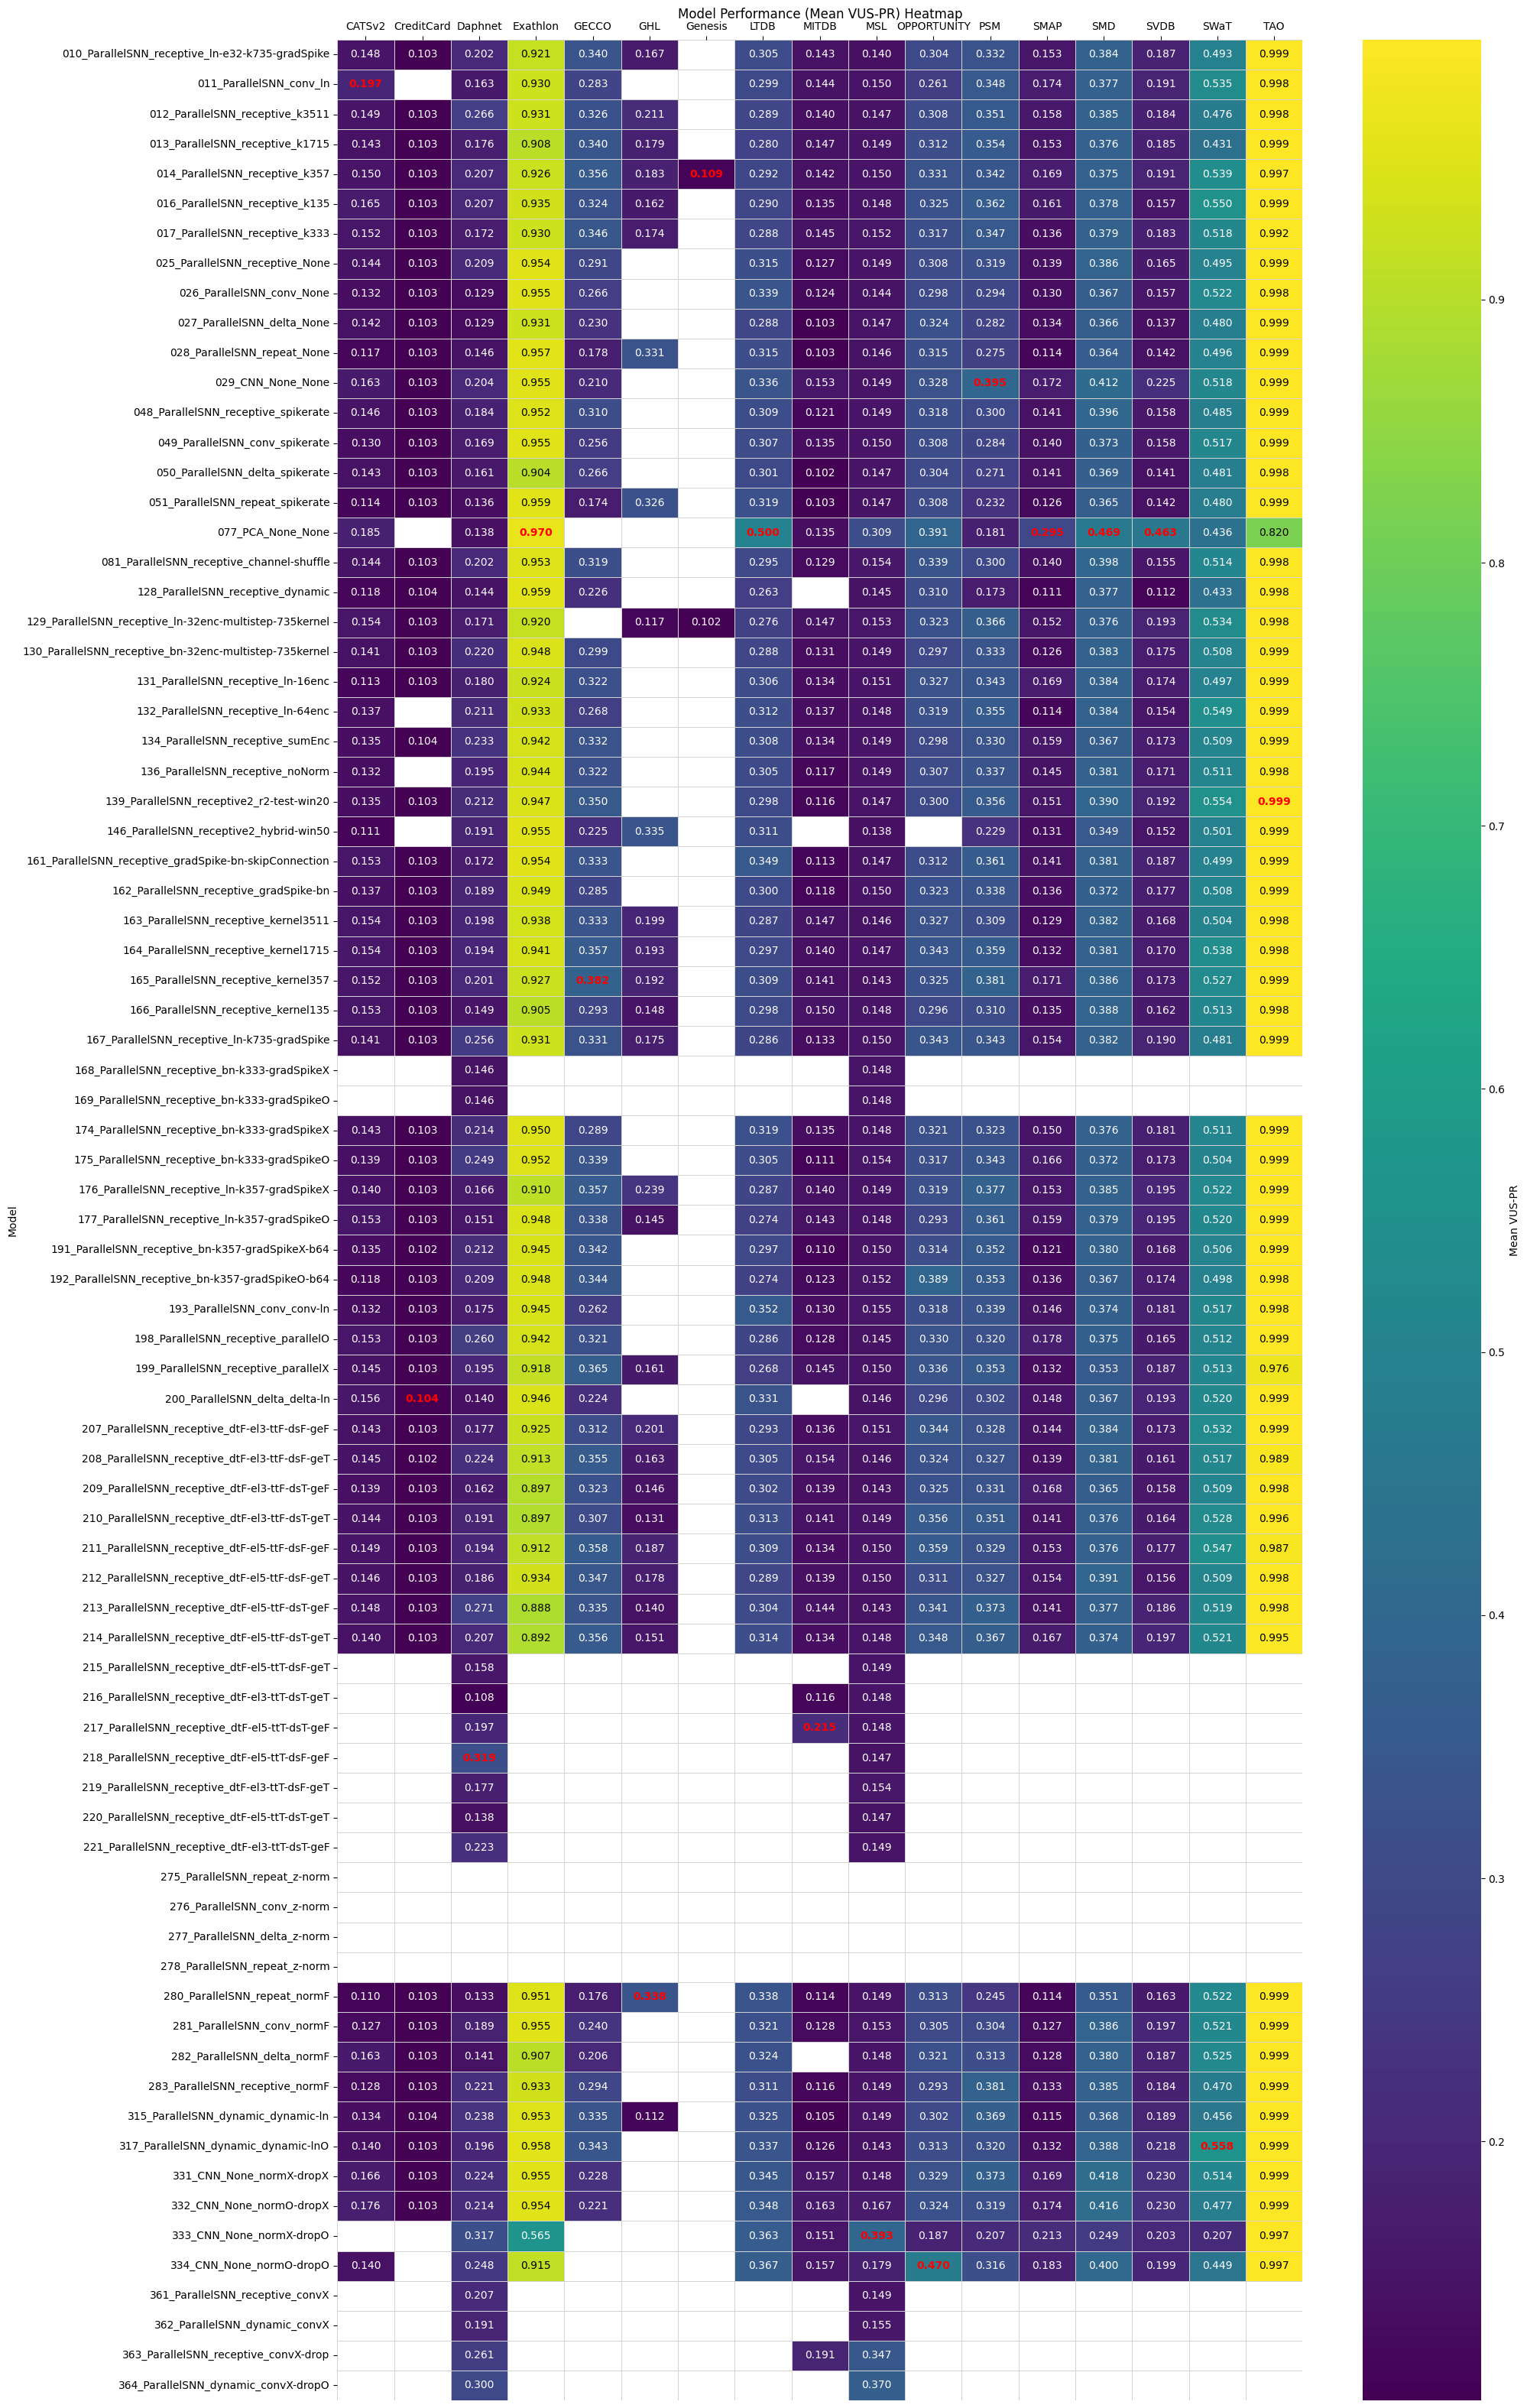

In [9]:
viz_heatmap(heatmap_df_vus_pr)

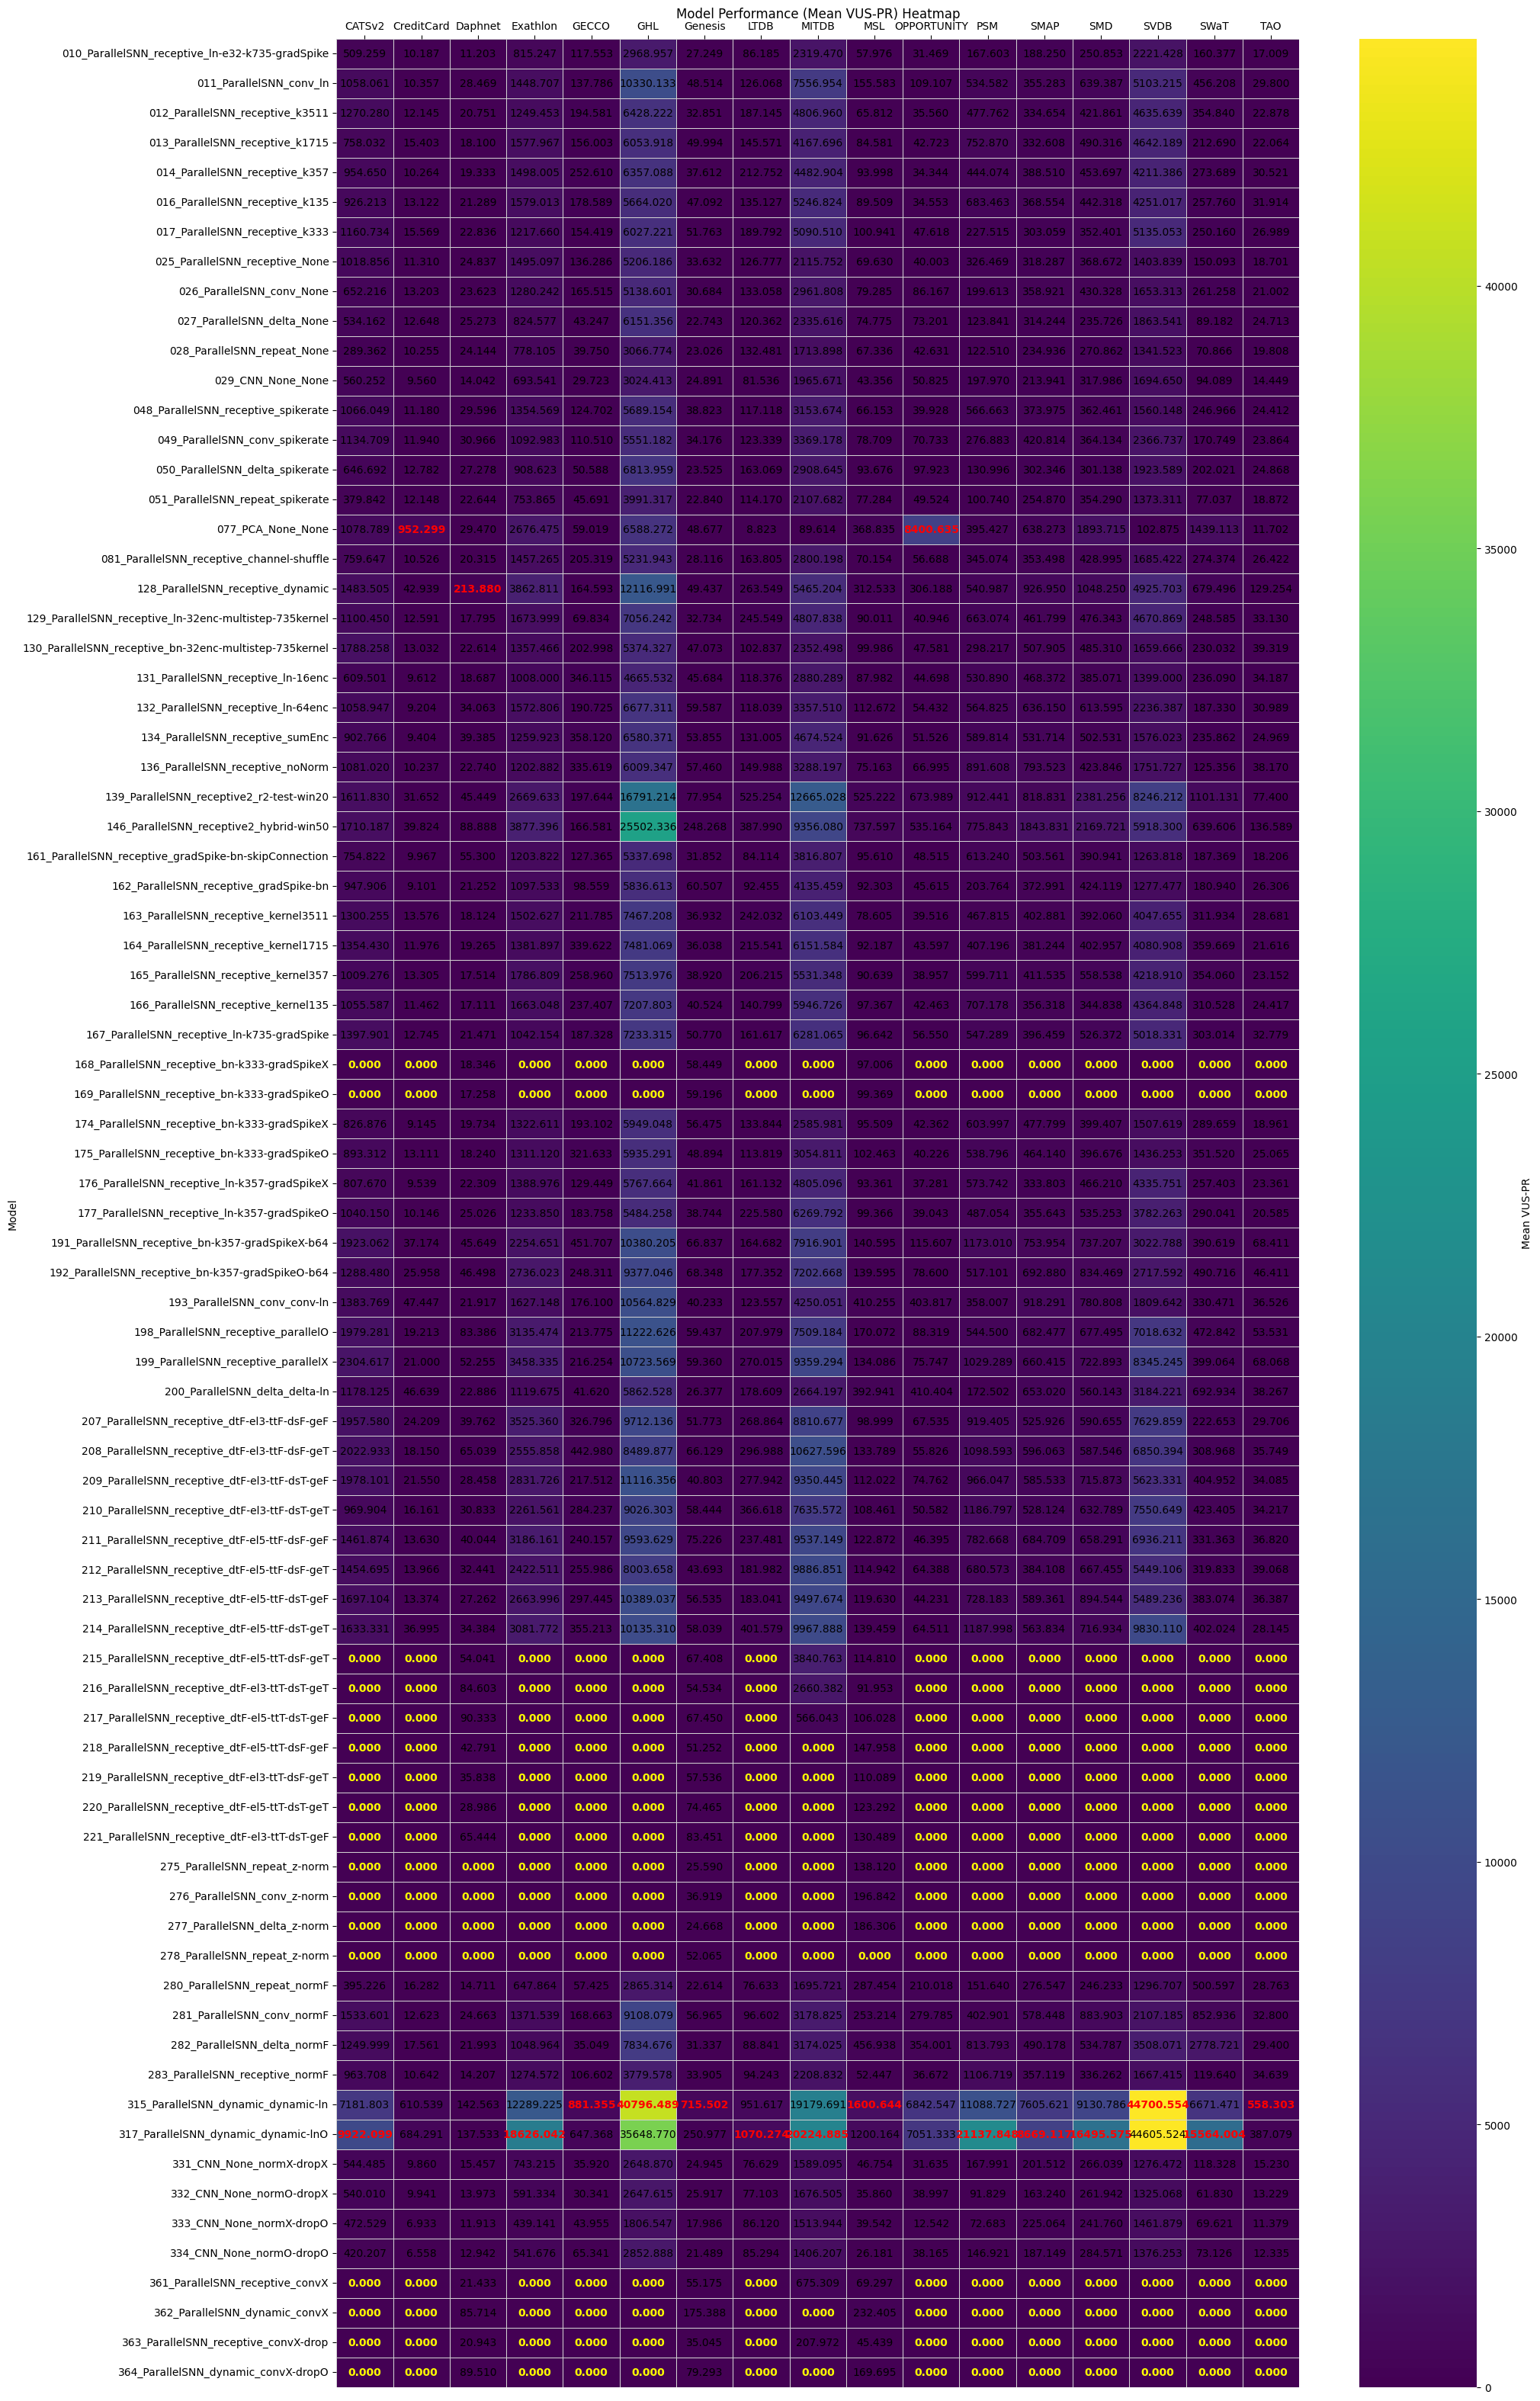

In [10]:
viz_heatmap(heatmap_df_time)